In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/컴퓨터비전개론_ICPBL_PROJECT

/content/drive/MyDrive/컴퓨터비전개론_ICPBL_PROJECT


In [3]:
!pip install bar_chart_race

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 1.1 MB/s eta 0:00:00


In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import bar_chart_race as bcr
import cv2
import numpy as np

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.relu=nn.ReLU(inplace=True)

        ## Hint: Please refer to above table for constructing layers
        # Construct block of RGB layers which takes RGB channel(3) as input
        # nn.Conv3D(input_channel, output_channel, kernel_size, padding)
        ########  rgb  #########
        self.rgb_block1 = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.rgb_block2 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.rgb_block3 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.rgb_block4 = nn.Sequential(
            nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )

        # Construct block of optical flow layers which takes the optical flow channel(2) as input
        ######## opt  #########
        self.opt_block1 = nn.Sequential(
            nn.Conv3d(2, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.opt_block2 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.opt_block3 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )
        self.opt_block4 = nn.Sequential(
            nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))
        )

        # Construct merging Block
        ######## merge  #########
        self.merge_block1 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
        )
        self.merge_block2 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
        )
        self.merge_block3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
        )
        ##########################################
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=2, batch_first=True)
        self.fc_lstm = nn.Linear(64, 2)
        #########################################
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)

        # Initialize weights
        self.__init_weight()

    def forward(self, x):
        #print("")
        #print("Initial shape:", x.shape)
        x = x.transpose(2,4)
        x = x.transpose(3,4)
        x = x.transpose(1,2)
        rgb = x[:,:3,:,:,:]
        opt = x[:,3:5,:,:,:]
        #print("After splitting RGB and Optical Flow, shape:", rgb.shape, opt.shape)
        # Pass through the RGB data through the blocks of RGB layers
        rgb = self.rgb_block1(rgb)
        rgb = self.rgb_block2(rgb)
        rgb = self.rgb_block3(rgb)
        rgb = self.rgb_block4(rgb)
        # Pass through the optical flow data through the blocks of RGB layers
        opt = self.opt_block1(opt)
        opt = self.opt_block2(opt)
        opt = self.opt_block3(opt)
        opt = self.opt_block4(opt)
        # Fuse by performing elementwise multiplication of rgb and opt tensors.
        fused = rgb * opt ## fill here ##
        # Perform maxpooling of fused
        fused = F.max_pool3d(fused, kernel_size=(8, 1, 1)) ## fill here ##

        # Pass through the fused data into merging block
        merged = self.merge_block1(fused)
        merged = self.merge_block2(merged)
        merged = self.merge_block3(merged)
 ###############################
        x = merged.view(merged.size(0), -1, 128)  # adjusting LSTM size
        x, _ = self.lstm(x)
        x = self.fc_lstm(x[:, -1, :])
 ###############################
        # Fully Connected Layers
        x = merged.view(merged.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # Perform weight initialization ("kaiming normal")
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [6]:
device = torch.device('cuda')

model = FusionModel().to(device)
# user your pretrained model path
model.load_state_dict(torch.load('test.pth'))

<All keys matched successfully>

In [7]:
def uniform_sampling(video, target_frames=64):
    # get total frames of input video and calculate sampling interval
    len_frames = int(len(video))
    interval = int(np.ceil(len_frames/target_frames))
    # init empty list for sampled video and
    sampled_video = []
    for i in range(0,len_frames,interval):
        sampled_video.append(video[i])
    # calculate numer of padded frames and fix it
    num_pad = target_frames - len(sampled_video)
    padding = []
    if num_pad>0:
        for i in range(-num_pad,0):
            try:
                padding.append(video[i])
            except:
                padding.append(video[0])
        sampled_video += padding
    # get sampled video
    return np.array(sampled_video, dtype=np.float32)


def normalize(data):
    mean = data.mean()
    std = data.std()
    return (data - mean) / std

In [47]:
from tqdm import tqdm
import cv2
import numpy as np
import torch

# Modified function to crop black borders and add a small border
def crop_black_borders(frame, threshold=10, border_size=10):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return frame
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    x = max(x - border_size, 0)
    y = max(y - border_size, 0)
    w = min(w + 2 * border_size, frame.shape[1] - x)
    h = min(h + 2 * border_size, frame.shape[0] - y)
    cropped_frame = frame[y:y+h, x:x+w]
    return cropped_frame

'''def crop_black_borders(frame, threshold=10):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return frame
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    cropped_frame = frame[y:y+h, x:x+w]
    return cropped_frame'''


# test video path
file_path = "Assault018_x264.mp4"
cap = cv2.VideoCapture(file_path)
len_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
frames = []
flows = []
preds = []
resize = (224, 224)

prev_frame = None
for iter in tqdm(range(len_frames-1), desc="Processing Frames"):
    ret, frame = cap.read()
    if not ret:
        break
    frame = crop_black_borders(frame)
    frame = cv2.resize(frame, resize, interpolation=cv2.INTER_AREA)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.reshape(frame, (224, 224, 3))
    frames.append(frame)

    img = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gray_img = np.reshape(img, (224, 224, 1))
    if prev_frame is None:
        prev_frame = gray_img

    flow = cv2.calcOpticalFlowFarneback(prev_frame, gray_img, None, 0.5, 3, 15, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    prev_frame = gray_img
    flow[..., 0] -= np.mean(flow[..., 0])
    flow[..., 1] -= np.mean(flow[..., 1])
    flow[..., 0] = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
    flow[..., 1] = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
    flows.append(flow)

    result = np.zeros((len(flows), 224, 224, 5))
    result[..., :3] = frames
    result[..., 3:] = flows

    data = np.float32(result)
    # # sampling 64 frames uniformly from the entire video
    data = uniform_sampling(video=data, target_frames=64)
    # normalize rgb images and optical flows, respectively
    data[..., :3] = normalize(data[..., :3])
    data[..., 3:] = normalize(data[..., 3:])
    fr, w, h, ch = data.shape
    data = data.reshape((-1, fr, w, h, ch))

    data = torch.Tensor(data).to(device)
    # pred = model.predict(data)[0]
    pred = model(data)

    # fights.append(pred[0])
    # none.append(pred[1])
    preds.append(pred[0].detach().cpu().numpy())

cap.release()

Processing Frames: 100%|██████████| 360/360 [05:33<00:00,  1.08it/s]


In [48]:
import pandas as pd

print(np.array(preds).shape)

group_list = ["Violence", "Non-Violence"]
df = pd.DataFrame(preds, columns = ['Violence', 'Non-Violence'])

df

(360, 2)


,Violence,Non-Violence
0,-0.505119,0.416272
1,-0.524037,0.451204
2,-0.518925,0.438817
3,-0.498789,0.424114
4,-0.497589,0.421047
...,...,...
355,0.106717,-0.227233
356,0.013205,-0.131207
357,0.026654,-0.145329
358,0.014048,-0.113599


In [49]:
len(df[df['Violence']>0])

106

In [50]:
len(df[df['Violence']>df['Non-Violence']])

159

In [51]:
bcr.bar_chart_race(df=df[:],
                   n_bars = 2,
                   figsize=(4, 4),
                   label_bars=False,
                   sort='desc',
                  #  title='Violence detection',
                   fixed_order=['Violence', 'Non-Violence'],
                   orientation='h',
                   fixed_max=True,
                   period_length=int(1000/fps),
                  )

## The section below is the test section, please ignore

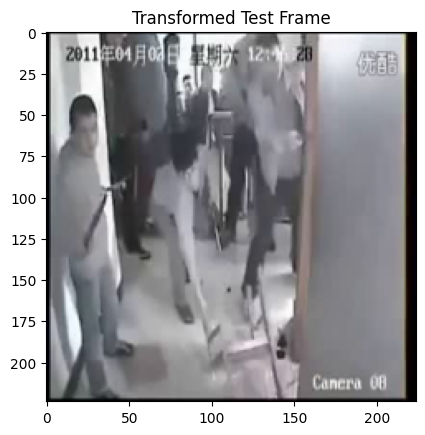

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_transformed_frame(file_path, resize_dim=(224, 224)):
    cap = cv2.VideoCapture(file_path)
    success, frame = cap.read()
    if success:

        frame = cv2.resize(frame, resize_dim, interpolation=cv2.INTER_AREA)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.title("Transformed Test Frame")
        plt.show()
    cap.release()

visualize_transformed_frame("train_video_test.avi")

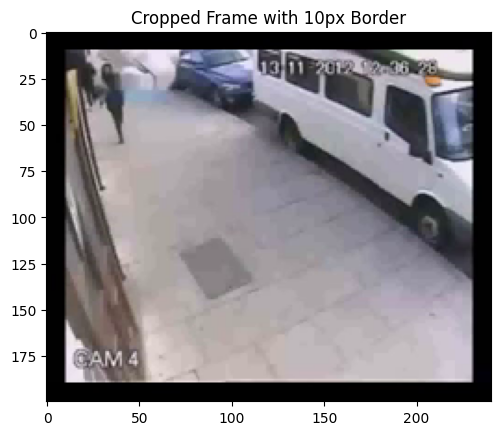

In [ ]:
def crop_black_borders(frame, threshold=10, border_size=10):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return frame
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    # Adjusting the rectangle to leave a small border
    x = max(x - border_size, 0)
    y = max(y - border_size, 0)
    w = min(w + 2 * border_size, frame.shape[1] - x)
    h = min(h + 2 * border_size, frame.shape[0] - y)

    cropped_frame = frame[y:y+h, x:x+w]
    return cropped_frame

def visualize_cropped_frame(file_path, threshold=10, border_size=10):
    cap = cv2.VideoCapture(file_path)
    ret, frame = cap.read()
    if not ret:
        print("Failed to read the frame.")
        cap.release()
        return

    processed_frame = crop_black_borders(frame, threshold, border_size)
    plt.imshow(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Cropped Frame with {border_size}px Border")
    plt.show()

    cap.release()

visualize_cropped_frame("Assault018_x264.mp4", threshold=10, border_size=10)


In [ ]:
def check_frame_sampling(file_path, target_frames=64):
    cap = cv2.VideoCapture(file_path)
    len_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = int(np.ceil(len_frames / target_frames))
    sampled_frames = len_frames // interval

    print(f"Total frames: {len_frames}, Sampled frames: {sampled_frames}, Expected frames: {target_frames}")

print(check_frame_sampling("Assault018_x264.mp4"))
print(check_frame_sampling("train_video_test.avi"))

Total frames: 361, Sampled frames: 60, Expected frames: 64
None
Total frames: 150, Sampled frames: 50, Expected frames: 64
None


In [ ]:
def check_model_loading(model_path, model):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")

check_model_loading("changed_skeleton.pth", model)

Model loaded successfully.


In [ ]:
def preprocess_frame(frame, crop=False, target_size=(224, 224)):
    if crop:
        # Implement cropping logic here based on your video content
        pass
    else:
        # Resize with aspect ratio preservation
        h, w, _ = frame.shape
        scale = min(target_size[0] / h, target_size[1] / w)
        new_h, new_w = int(h * scale), int(w * scale)
        resized_frame = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_AREA)
        # Add black borders if necessary
        delta_w = target_size[1] - new_w
        delta_h = target_size[0] - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        frame = cv2.copyMakeBorder(resized_frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return frame
preprocess_frame()

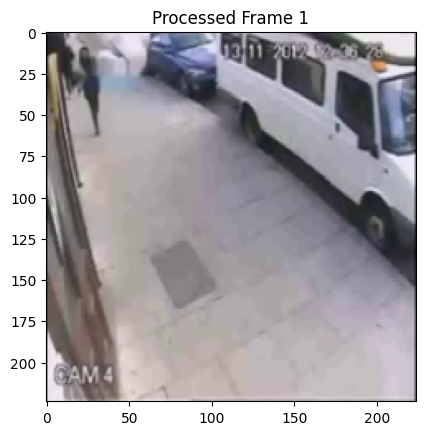

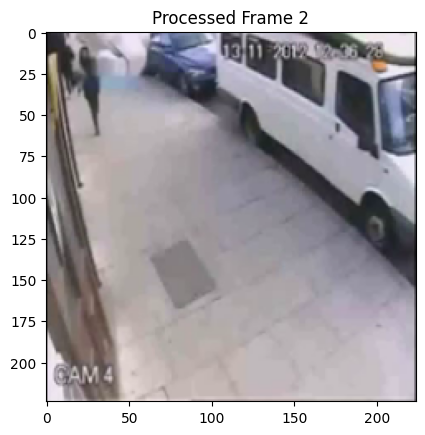

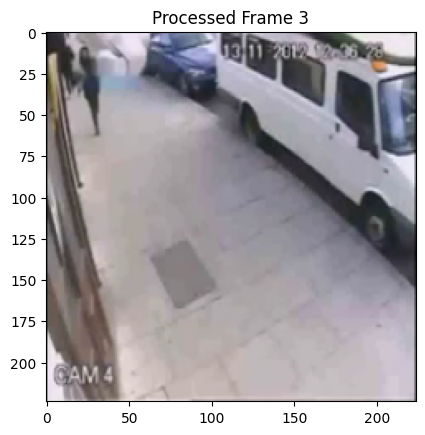

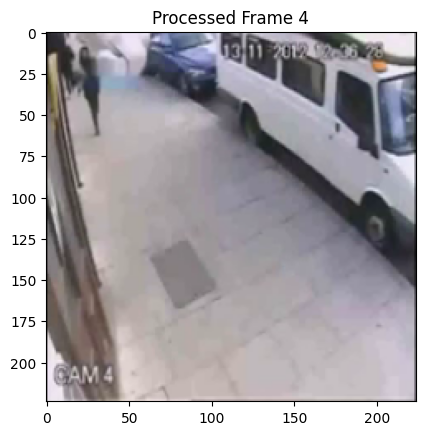

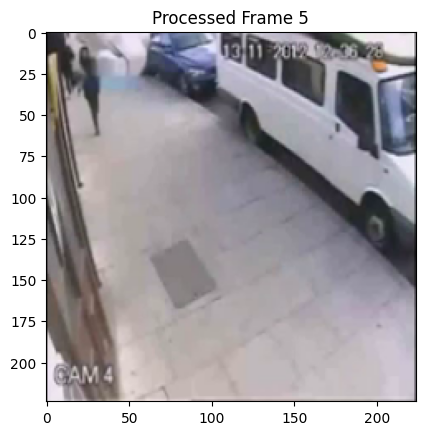

In [ ]:
def crop_black_borders(frame, threshold=10):
    # Convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Thresholding to find the non-black areas
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return frame  # Return original frame if no contours are found

    # Find the largest contour and its bounding box
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    # Crop the frame
    cropped_frame = frame[y:y+h, x:x+w]

    return cropped_frame

def preprocess_and_crop_frame(frame, target_size=(224, 224)):
    # Crop black borders
    frame = crop_black_borders(frame)

    # Resize the frame to the target size
    resized_frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_AREA)

    return resized_frame

def visualize_processed_frames(file_path, num_frames=5):
    cap = cv2.VideoCapture(file_path)
    frames_processed = 0
    while frames_processed < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = preprocess_and_crop_frame(frame)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Processed Frame {frames_processed + 1}")
        plt.show()
        frames_processed += 1
    cap.release()

# Call this function with the path to your test video
visualize_processed_frames("Assault018_x264.mp4")

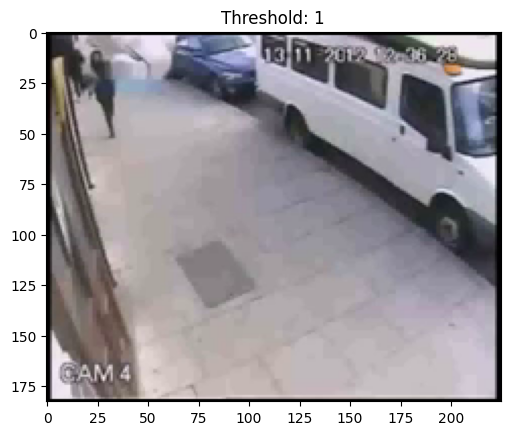

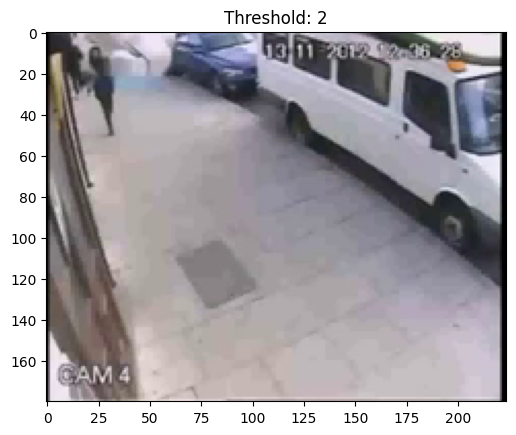

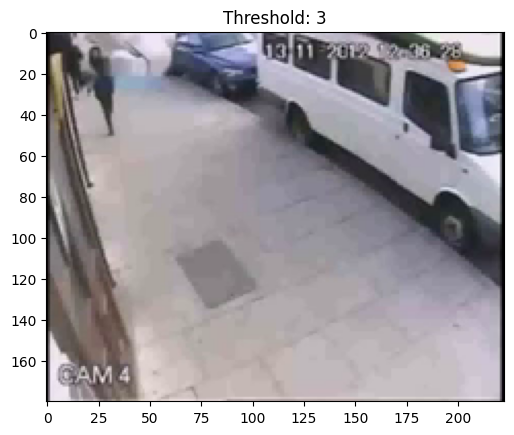

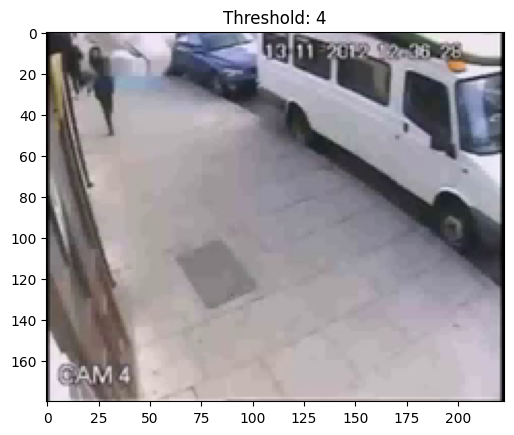

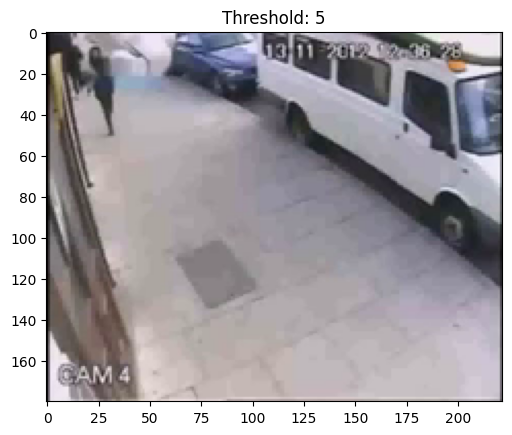

In [ ]:
import cv2
import matplotlib.pyplot as plt

def crop_black_borders(frame, threshold=10):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return frame
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    cropped_frame = frame[y:y+h, x:x+w]
    return cropped_frame

def visualize_frame_with_threshold(file_path, threshold_values):
    cap = cv2.VideoCapture(file_path)
    ret, frame = cap.read()
    if not ret:
        print("Failed to read the frame.")
        cap.release()
        return

    for threshold in threshold_values:
        processed_frame = crop_black_borders(frame, threshold=threshold)
        plt.imshow(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Threshold: {threshold}")
        plt.show()

    cap.release()

# List of thresholds to try
threshold_values = [1,2,3,4,5]
visualize_frame_with_threshold("Assault018_x264.mp4", threshold_values)
